<a href="https://colab.research.google.com/github/shayongithub/vnuk-ai-challenge2/blob/master/Image_Captioning_with_Flickr8k_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/') 

Mounted at /content/gdrive/


In [2]:
cd gdrive/MyDrive/VNUK-AI/Challenge\ 2

/content/gdrive/MyDrive/VNUK-AI/Challenge 2


In [ ]:
pwd


'/content/gdrive/MyDrive/VNUK-AI/Challenge 2'

## Load needed libraries 

In [3]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
import cv2

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu

In [4]:
# Load all the caption 
def load_doc(filepath):
    # open the file as read only
    file = open(filepath, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    
    return text

filepath = "Flickr8k/Flickr8k_text/Flickr8k.token.txt"

doc = load_doc(filepath)
doc
# Exam the first 400 characters
print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


In [5]:
# For each image, we have 5 captions. So we gonna save all the caption in a dictionary in format:
# id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']

def load_descriptions(doc):
    mapping = dict()
    # go through each line
    for line in doc.split('\n'):
        # split words by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        
        # add image_id as key and create the list for holding captions
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Images Loaded: %d ' % len(descriptions))

Images Loaded: 8092 


In [6]:
# Looking at some caption of images
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

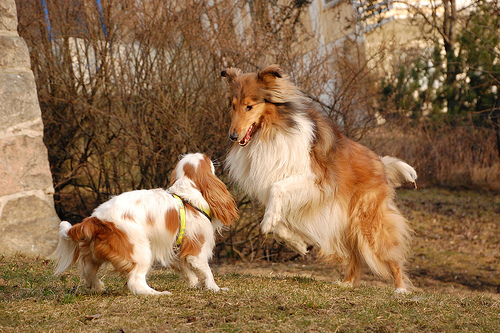

A Collie and a Springer Spaniel playing outside .
The large brown and white dog is jumping towards the small brown and white dog .
Two brown and white dogs fighting on a grassy area in front of a tree .
Two brown and white dogs in the grass near a stone structure .
Two tan and white dogs look at each other in an outdoor setting .


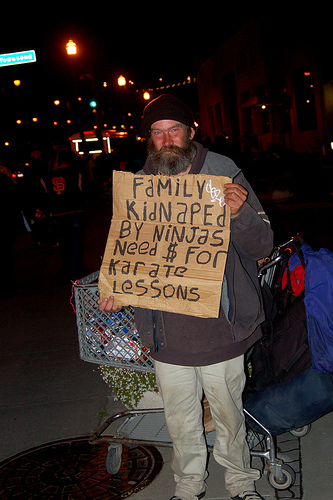

A bearded man is standing by a shopping cart holding up a cardboard sign .
A guy holding a sign , with a shopping cart .
a homeless man holding a sign written on cardboard
A man holds a sign seeking money .
homeless man begging for money using humorous sign .


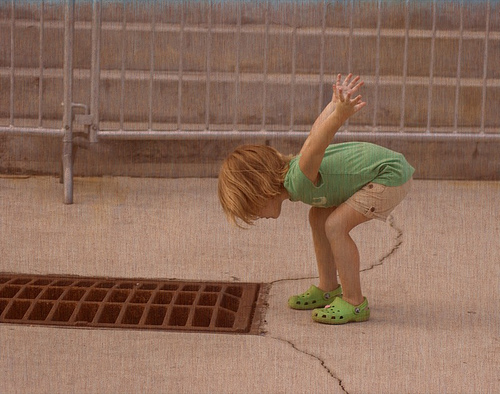

A child in green shoes staring down a drain .
A young child in a green shirt and crocks looking down a drain
Blond girl looking down the grating on the road .
The little girl in green bends down the check out the drainpipe .
The small child in green crocks leans over to look inside a grate .


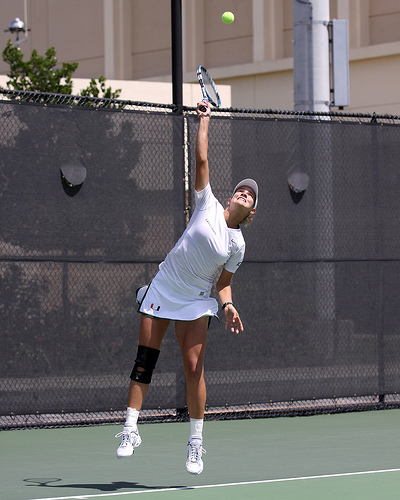

A female tennis player hitting the ball
A woman in a white tennis outfit has jumped into the air to hit a tennis ball .
A woman in a white tennis outfit is jumping up to hit the ball .
A woman wearing white jumps up to hit the ball during a tennis match .
A woman wearing white reaches high above herself to hit a tennis ball .


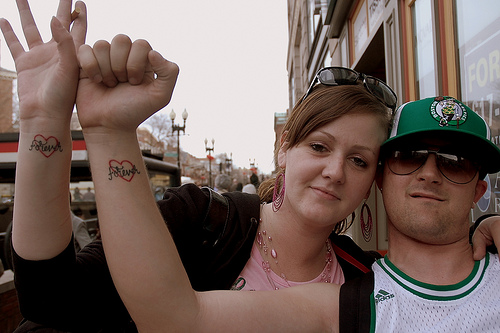

A girl with a cigarette in hand and a guy with a green hat wave at the camera .
A man and a woman show their tatooed hearts on their wrists
a man and woman hug .
A man in a green Celtics hat and a woman wearing a black sweater display identical tattoos on their right wrists .
There is a man and woman holding up their arms and showing their heart tattoos .


In [7]:
def display_random_data(count=5, seed=42):
    np.random.seed(seed)
    # random choose number of images == count
    images = np.random.choice(list(descriptions), count)    
    # display and their captions
    for image in images:
        # display image
        display(Image.open(f'Flickr8k/Flicker8k_Dataset/{image}.jpg'))
        # display caption
        img_captions = descriptions[image]
        for caption in img_captions:
            print(caption)
display_random_data()

## Prepare data for training
- Preprocessing the caption:  
  + Convert to lowercase
  + Remove special character
  + Remove word with numbers (e.g. hey199)
  + Add start and ending token
- Preprocessing the images:
  + Resize images to fit into pre-trained model (e.g. VGG16, ResNet,etc) in order to extract features 

In [8]:
# Preprocessing text 
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    
    for image_id, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [9]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
# Save descriptions.txt
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [11]:
# Take the id corresponding with train, test and dev set
def load_dataset(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get only the id of image and rid of '.jpg'
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
train_filename = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# load testing dataset (1K)
test_filename = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# load validate dataset (1K)
dev_filename = 'Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'

train_id = load_dataset(train_filename)
test_id = load_dataset(test_filename)
validate_id = load_dataset(dev_filename)

print('Train set: %d' % len(train_id))
print('Test set: %d' % len(test_id))
print('Validate set: %d' % len(validate_id))

Train set: 6000
Test set: 1000
Validate set: 1000


In [12]:
# Images directory
img_dir = 'Flickr8k/Flicker8k_Dataset/'
# Save all the images path
imgs_path = glob.glob(img_dir + '*.jpg')

In [13]:
# File contains train id images
train_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in imgs_path:
    if i[len(img_dir):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [14]:
# File contains test id images
test_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in imgs_path:
    if i[len(img_dir):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [15]:
# File contains valdiate id images
val_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
# Read the valdiate image names in a set
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Create a list of all the valdiate images with their full path names
val_img = []

for i in imgs_path: 
    if i[len(img_dir):] in val_images: # Check if the image belongs to valdiate set
        val_img.append(i) # Add it to the list of valdiate images

In [16]:
# Adding token 'startseq', 'endseq' 
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list to contain captions
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# Loop through all the images in the descriptions but take only the images in train set
train_descriptions = load_clean_descriptions('descriptions.txt', train_id)
print('Descriptions: train = %d' % len(train_descriptions))

Descriptions: train = 6000


In [17]:
def load_normal_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = ' '.join(image_desc)
			# store
			descriptions[image_id].append(desc)
	return descriptions

test_descriptions = load_normal_descriptions('descriptions.txt', test_id)
val_descriptions = load_normal_descriptions('descriptions.txt', validate_id)
print('Descriptions: test = %d' % len(test_descriptions))
print('Descriptions: val = %d' % len(val_descriptions))

Descriptions: test = 1000
Descriptions: val = 1000


In [18]:
# Load images and resize to (299, 299) as it is the size that Inception V3 required
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

## Transfer Learning to Extract features from Images

In [19]:
# Load the inception v3 model
model_inceptionv3 = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [20]:
# Take a first look into the layer of Inception V3 model
model_inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [21]:
# Remove the last layer 'predictions' as we dont need it for predicting anything but extracting features
model_inceptionv3 = Model(model_inceptionv3.input, model_inceptionv3.layers[-2].output)

In [22]:
# Image embedding into vector of (2048, ) (this is the output of InceptionV3 model)
def encode(image):
    image = preprocess(image) # preprocess the image
    feature_vec = model_inceptionv3.predict(image) # Get the encoding vector for the image
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return feature_vec

In [ ]:
# Encoding images and forming dictionaries containing mapping of image_id to image encodings
start = time()
encoding_train = {}
for img in train_img:
    # Take only from the id of the image instead of full path
    encoding_train[img[len(img_dir):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 813.2290828227997


In [ ]:
# Save embedded file for avoiding encoding again (cost a lot of times)
# wb stands for write binary
with open("Flickr8k/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [ ]:
# Do the same encode thing with test image
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(img_dir):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 103.04017090797424


In [ ]:
with open("Flickr8k/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [ ]:
# Similar with validate set
start = time()
encoding_val = {}
for img in val_img:
    encoding_val[img[len(img_dir):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 103.36504244804382


In [ ]:
with open("Flickr8k/Pickle/encoded_val_images.pkl", "wb") as encoded_pickle:
    dump(encoding_val, encoded_pickle)

In [23]:
train_features = load(open("Flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train = %d' % len(train_features))

Photos: train = 6000


In [24]:
# Create a list for containing all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)#30000

30000

## Word Selection
As we have over 30000 captions, there will be a lot words but it only happens a few times, and not signigicant to our model and rather than a noise. So we only use words that appear more than 10 times to make our model more efficient.

In [47]:
# Extract words that appear more than 10 times
word_count_threshold = 7
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 2056


## Tokenizing the vocabulary

In [48]:
# word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [49]:
vocab_size = len(ixtoword) + 1 # Plus 1 for word used as padding
vocab_size

2057

In [50]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


## Glove vector embeddings

In [51]:
# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [52]:
embeddings_index['the']

array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
        3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
        1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
       -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
        4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
        7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
        1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
       -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
       -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
        6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
       -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
        8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
        1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
        1.4379e-01, -1.2325e-01, -5.8178e-02, -1.0290e-03, -8.21

In [53]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 1652 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    # Words not found in the embedding index will be all zeros
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [54]:
embedding_matrix.shape

(2057, 200)

## Create Our RNN 

In [33]:
# Create our RNN model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

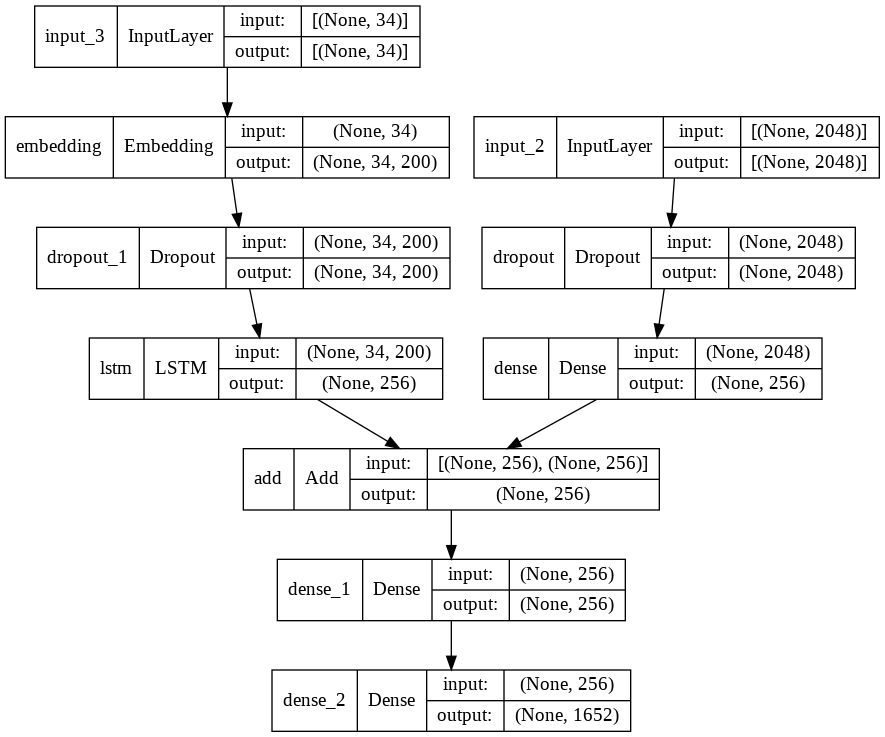

In [34]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [36]:
# The Embedding layer use Glove model so we dont have to train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [37]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save('saved_model/lstm_model_10freq.h5')
print('Model Save Successfully')

 909/1000 [==========================>...] - ETA: 17s - loss: 3.3747

## Test model

In [40]:
model = tf.keras.models.load_model('saved_model/lstm_model_7freq.h5')

In [41]:
images_dir = 'Flickr8k/Flicker8k_Dataset/'

In [55]:
# load encoded images
with open("Flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

### **Greedy Search** 

In [43]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='startseq'
  for i in range(max_length):
    sequence = [wordtoix[s] for s in in_text.split(" ") if s in wordtoix]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = ixtoword[y_pred]
    in_text += ' ' + word
    if word == 'endseq':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

### Predicting Captions on Test Set using Greedy Search

488408004_a1e26d4886.jpg


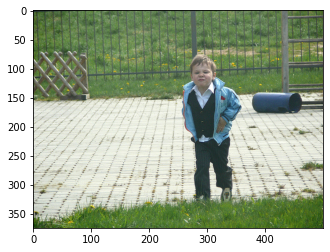

Reference Captions: 
	child in formal clothing is walking along the edge of stony area that is littered in places
	little boy with blue jacket is making sour face at the camera
	young boy wearing light blue jacket walks across the brick patio
	young boy with blue coat makes funny face as he walks towards the grass
	the young boy is walking wearing blue jacket black sweater and white collared shirt
Predicted Caption: 
	man in red shirt and jeans walks down sidewalk
Bleu score:  0.6537993517025207
2484190118_e89363c465.jpg


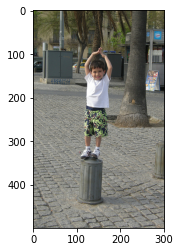

Reference Captions: 
	boy with his hands above his head stands on cement pillar above the cobblestones
	child in colorful shorts is standing on post in the street
	small boy stands on cement stump in park with his hands on his head
	young man wearing white tshirt and green and black shorts standing on stump
	small child in white shirt and print shorts with hands over their head standing on object
Predicted Caption: 
	two girls are walking on sidewalk
Bleu score:  0.27768352844338134
3591462960_86045906bd.jpg


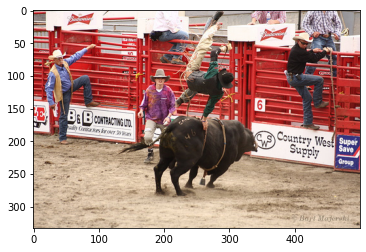

Reference Captions: 
	man is roping bull in rodeo while others in cowboy hats watch
	man is up in the air with one hand on bull
	rodeo rider gets tossed up into the air by black bull as fellow cowboys look on
	man getting thrown in the air while bull riding
	the man in black is flying off the full in front of red fence
Predicted Caption: 
	two dogs are playing in the grass
Bleu score:  0.351043582995851
150387174_24825cf871.jpg


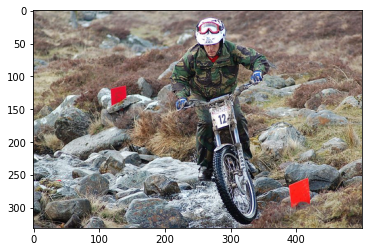

Reference Captions: 
	man dressed in camouflage riding motorbike
	man is going between two red flag markers on dirt bike
	man is riding dirt bike over some rocks
	man wearing camouflage steers motorcycle across some stones
	the man waeribng helmet is riding dirt bike over rocks
Predicted Caption: 
	man in red shirt is riding bike on the woods
Bleu score:  0.5460241725418133
370614351_98b8a166b9.jpg


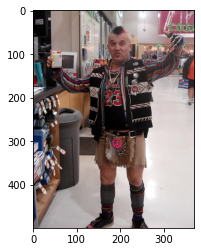

Reference Captions: 
	man with mohawk with his arms in the air
	man with multicolored hair wearing weird outfit
	person in kilt and sports jersey and mohawk is in store
	punk rocker buys computer ink in the bigbox store
	the man with the eccentric clothing and hair poses in store
Predicted Caption: 
	man in red hat and black hat and black hat is standing on the street
Bleu score:  0.7952707287670506
3567061016_62768dcce1.jpg


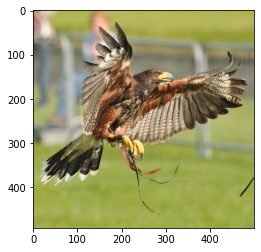

Reference Captions: 
	bird flying in the air
	bird flies low to the ground
	bird with its wings spread
	hawk flies down towards the grass
	hawk is flying trailing lines from its legs
Predicted Caption: 
	the man is playing with his mouth
Bleu score:  0.8091067115702212
2844018783_524b08e5aa.jpg


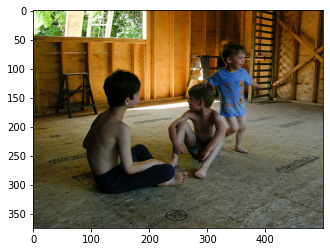

Reference Captions: 
	three boys in building under construction
	three boys play in an unfinished building
	three boys playing in an unfinished space
	three little boys are playing on the floor of an unfinished house
	two young boys sit and one young boy stands on an unfinished wooden floor
Predicted Caption: 
	two children are playing on the grass
Bleu score:  0.4347208719449914
3044746136_8b89da5f40.jpg


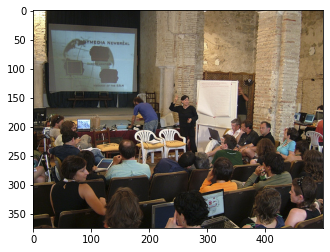

Reference Captions: 
	class full of students
	classroom of students watching presentation
	conference is being held that involves laptops and big screen presentations
	group of people are at conference watching slideshow
	man is giving presentation in front of lot of people
Predicted Caption: 
	group of people are sitting in front of people
Bleu score:  0.43167001068522526
3107513635_fe8a21f148.jpg


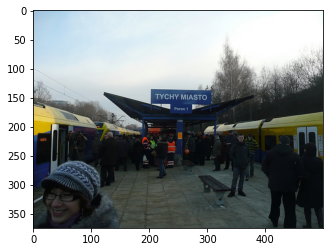

Reference Captions: 
	bunch of people at train station
	photo of train platform on chilly day
	train station says tychy miasto
	people are boarding two yellow and blue trains
	several people waiting outside train station
Predicted Caption: 
	man in red shirt is standing in front of building
Bleu score:  0.5623413251903491
3729525173_7f984ed776.jpg


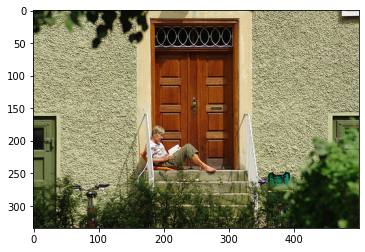

Reference Captions: 
	lady sitting on front porch reading book
	person sits at doorstep and reads book
	woman is reading literature and sitting on the front stoop of building
	woman sits and reads in the stoop of wooden door
	woman sits and reads on the front stoop of her building
Predicted Caption: 
	two children are sitting on sidewalk
Bleu score:  0.43012508513132625


In [ ]:
def predict_encoded_images_greedy(encoding_images, image_descriptions, num_predict = 10):
    i = 0
    for img_id in encoding_images:
        print(img_id)
        i+=1
        img = cv2.imread(images_dir + img_id)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        photo = encoding_test[img_id]
        plt.show()
        reference=[]

        for caps in image_descriptions[img_id[:-4]]:
            list_caps = caps.split(" ")
            reference.append(list_caps)

        candidate = greedy_search(photo)
        score = sentence_bleu(reference, candidate)

        print("Reference Captions: ")
        for cap in reference:
            print("\t" + " ".join(cap))
        print("Predicted Caption: ")
        print("\t" +" ".join(candidate))
        print("Bleu score: ",score)

        if(i == num_predict):
            break

predict_encoded_images_greedy(encoding_test, test_descriptions)

### Calculating Average Bleu Score on Test Set using Greedy Search

In [ ]:
i=0
tot_score=0
for img_id in encoding_test:
  i+=1
  photo = encoding_test[img_id]
  reference=[]
  for caps in test_descriptions[img_id[:-4]]:
    list_caps=caps.split(" ")
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)


Bleu score on Greedy search
Score:  0.5697349717462646


### **Beam Search**

In [56]:
def beam_search(photo,k):

  photo=photo.reshape(1,2048)
  in_text = 'startseq'
  sequence = [wordtoix[s] for s in in_text.split(" ") if s in wordtoix]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)

  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]

  for i in range(k):
    word = ixtoword[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1] == 'endseq':
        break
      sequence = [wordtoix[s] for s in text[0].split(" ") if s in wordtoix]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)

      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]

      for i in range(k):
        word = ixtoword[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]

  final = b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

### Predicting Captions on Test Set using Beam Search

488408004_a1e26d4886.jpg


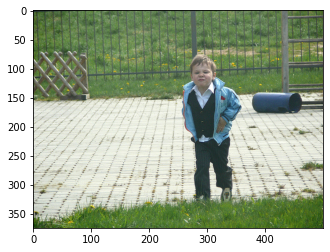

Reference Captions: 
	child in formal clothing is walking along the edge of stony area that is littered in places
	little boy with blue jacket is making sour face at the camera
	young boy wearing light blue jacket walks across the brick patio
	young boy with blue coat makes funny face as he walks towards the grass
	the young boy is walking wearing blue jacket black sweater and white collared shirt
Predicted Caption: 
	man and woman walking on sidewalk
Bleu score:  0.3302232277439296
2484190118_e89363c465.jpg


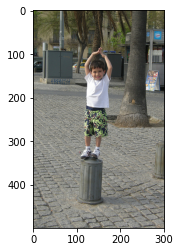

Reference Captions: 
	boy with his hands above his head stands on cement pillar above the cobblestones
	child in colorful shorts is standing on post in the street
	small boy stands on cement stump in park with his hands on his head
	young man wearing white tshirt and green and black shorts standing on stump
	small child in white shirt and print shorts with hands over their head standing on object
Predicted Caption: 
	two girls are standing on the sidewalk
Bleu score:  0.2919441086311216
3591462960_86045906bd.jpg


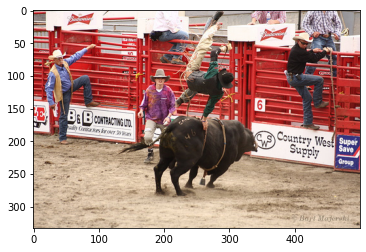

Reference Captions: 
	man is roping bull in rodeo while others in cowboy hats watch
	man is up in the air with one hand on bull
	rodeo rider gets tossed up into the air by black bull as fellow cowboys look on
	man getting thrown in the air while bull riding
	the man in black is flying off the full in front of red fence
Predicted Caption: 
	two dogs play in the grass
Bleu score:  0.3081980909598119
150387174_24825cf871.jpg


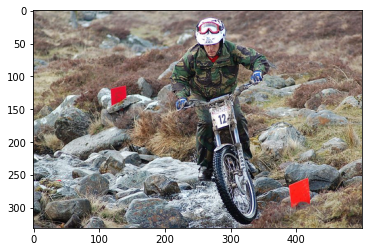

Reference Captions: 
	man dressed in camouflage riding motorbike
	man is going between two red flag markers on dirt bike
	man is riding dirt bike over some rocks
	man wearing camouflage steers motorcycle across some stones
	the man waeribng helmet is riding dirt bike over rocks
Predicted Caption: 
	man is riding bike on dirt path
Bleu score:  0.5410822690539396
370614351_98b8a166b9.jpg


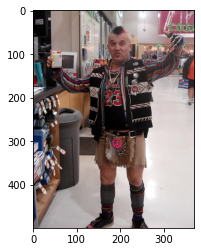

Reference Captions: 
	man with mohawk with his arms in the air
	man with multicolored hair wearing weird outfit
	person in kilt and sports jersey and mohawk is in store
	punk rocker buys computer ink in the bigbox store
	the man with the eccentric clothing and hair poses in store
Predicted Caption: 
	man wearing red hat and hat is standing in front of store
Bleu score:  0.8408964152537145
3567061016_62768dcce1.jpg


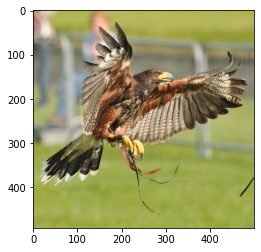

Reference Captions: 
	bird flying in the air
	bird flies low to the ground
	bird with its wings spread
	hawk flies down towards the grass
	hawk is flying trailing lines from its legs
Predicted Caption: 
	the little boy is playing in the water
Bleu score:  0.48109772909788073
2844018783_524b08e5aa.jpg


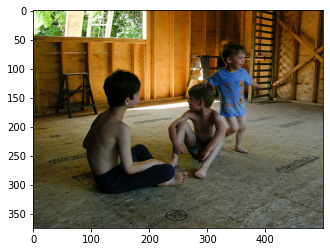

Reference Captions: 
	three boys in building under construction
	three boys play in an unfinished building
	three boys playing in an unfinished space
	three little boys are playing on the floor of an unfinished house
	two young boys sit and one young boy stands on an unfinished wooden floor
Predicted Caption: 
	two boys are playing in the water
Bleu score:  0.5410822690539396
3044746136_8b89da5f40.jpg


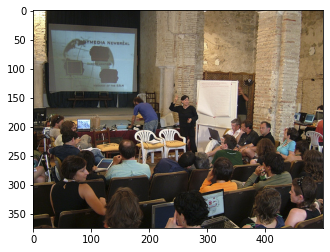

Reference Captions: 
	class full of students
	classroom of students watching presentation
	conference is being held that involves laptops and big screen presentations
	group of people are at conference watching slideshow
	man is giving presentation in front of lot of people
Predicted Caption: 
	group of people are gathered in front of building
Bleu score:  0.43167001068522526
3107513635_fe8a21f148.jpg


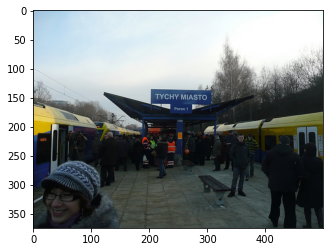

Reference Captions: 
	bunch of people at train station
	photo of train platform on chilly day
	train station says tychy miasto
	people are boarding two yellow and blue trains
	several people waiting outside train station
Predicted Caption: 
	two people are standing in front of building
Bleu score:  0.5169731539571706
3729525173_7f984ed776.jpg


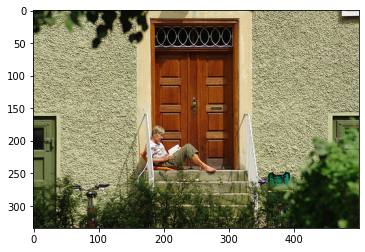

Reference Captions: 
	lady sitting on front porch reading book
	person sits at doorstep and reads book
	woman is reading literature and sitting on the front stoop of building
	woman sits and reads in the stoop of wooden door
	woman sits and reads on the front stoop of her building
Predicted Caption: 
	man in red shirt is jumping off of building
Bleu score:  0.43443712531357925


In [58]:
def predict_encoded_images_beam(encoding_images, image_descriptions, k_beam, num_predict = 10):
    i = 0
    for img_id in encoding_images:
        print(img_id)
        i+=1
        img = cv2.imread(images_dir + img_id)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        photo = encoding_test[img_id]
        plt.show()
        reference=[]

        for caps in image_descriptions[img_id[:-4]]:
            list_caps = caps.split(" ")
            reference.append(list_caps)

        candidate = beam_search(photo, k_beam)
        score = sentence_bleu(reference, candidate)

        print("Reference Captions: ")
        for cap in reference:
            print("\t" + " ".join(cap))
        print("Predicted Caption: ")
        print("\t" +" ".join(candidate))
        print("Bleu score: ",score)

        if(i == num_predict):
            break

predict_encoded_images_beam(encoding_test, test_descriptions, k_beam = 3)

### Calculating Average Bleu Score on Test Set using Beam Search

In [59]:
i=0
tot_score=0
for img_id in encoding_test:
  i+=1
  photo=encoding_test[img_id]
  reference=[]
  for caps in test_descriptions[img_id[:-4]]:
    list_caps=caps.split(" ")
    reference.append(list_caps)
  candidate = beam_search(photo, 3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)




Bleu score on Beam search with k=3
Score:  0.5568023920528056
